In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time


In [3]:
RANDOM_SEED = 47

In [4]:
hours = np.arange(0,25,1)
share = [0.0010, 0.0010, 0.0010, 0.0020, 0.0050, 0.0150, 0.0501, 0.1022, 0.0581, 0.0411, 0.0481, 0.0571, 0.0571,
               0.0521, 0.0651, 0.0982, 0.0852, 0.0832, 0.0651, 0.0451, 0.0301, 0.0220, 0.0100, 0.0050, 0]

In [5]:
hours

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [6]:
INPUT_DIURNAL_FILE = r'C:\Projects\SWIFT\SWIFT_Workspace\CommonData\STM\STM_A\Shared_Inputs\Diurnal_Full.csv'
df_input_diurnal = pd.read_csv(INPUT_DIURNAL_FILE)
df_input_diurnal

,HOUR,SHARE
0,0.000000,0.000100
1,0.100418,0.000104
2,0.200837,0.000106
3,0.301255,0.000107
4,0.401674,0.000108
5,0.502092,0.000108
6,0.602510,0.000107
7,0.702929,0.000106
8,0.803347,0.000104
9,0.903766,0.000102


In [7]:
xs, ys = df_input_diurnal.HOUR.values, df_input_diurnal.SHARE.values

In [8]:
input_diurnal_am_total = np.sum(ys[np.where((xs>=6) & (xs<9))])
input_diurnal_md_total = np.sum(ys[np.where((xs>=9) & (xs<15))])
input_diurnal_pm_total = np.sum(ys[np.where((xs>=15) & (xs<19))])
input_diurnal_ov_total = np.sum(ys[np.where((xs>=19) & (xs<24) | (xs>=0) & (xs<6))])
input_diurnal_period_totals = [input_diurnal_am_total, input_diurnal_md_total, input_diurnal_pm_total, input_diurnal_ov_total]
input_diurnal_period_totals

[0.211483, 0.35010399999999997, 0.307502, 0.13091000000000003]

In [9]:
omx_period_totals = [0.138051, 0.355870, 0.327969 ,0.178110]
omx_period_totals

[0.138051, 0.35587, 0.327969, 0.17811]

In [10]:
SAMPLE_SIZE = 30_000_000

### DT Generator Class

In [11]:
class DTGenerator:
    def __init__(self, x, prob, seed=0, interp=0, logger=None):
        """

        :param x:      x values for the probability density
        :param prob:   probabilities
        :param seed:   random seed
        :param interp: number of interpolation points
        :param logger: number of interpolation points
        """
        self._prob = prob
        self._x = x
        self._seed = seed
        self._interp = interp

        if len(x) != len(prob):
            if logger is not None:
                logger.error("The lengths of input distribution do not match")
            raise ValueError("The lengths of input distribution do not match")

        self._x_interp = self._x
        self._prob_interp = self._prob
        if interp:
            self._x_interp = np.linspace(x[0], x[-1], self._interp)
            interpolator = interp1d(self._x, self._prob, kind='cubic')
            self._prob_interp = interpolator(self._x_interp)
            self._prob_interp = self._prob_interp / sum(self._prob_interp)
        np.random.seed(self._seed)

    def _select_range(self, period=None):
        """

        :param period: period start and end times
        :type  list of tuples
        :return:
        """
        if period:
            selector = np.array([False]*len(self._x_interp))
            for p in period:
                selector = selector | ((self._x_interp >= p[0]) & (self._x_interp < p[1]))

            xs = self._x_interp[selector]
            probs = self._prob_interp[selector]
            probs = probs / np.sum(probs)
            return probs, xs
        return self._prob_interp, self._x_interp

    def dt(self, period, size=1):
        probs, xs = self._select_range(period)
        return np.random.choice(xs, p=probs, size=size)

In [12]:
dt_gen = DTGenerator(x=xs, prob=ys, interp=0, seed=RANDOM_SEED)

### Simulated with Input Diurnal Period Totals

In [13]:
trips = [int(SAMPLE_SIZE*s) for s in input_diurnal_period_totals]
periods = [[(6,9)], [(9,15)], [(15,19)], [(0,6),(19,24)]]

In [14]:
start = time.clock()
departure_times = np.array([])
for trip, period in zip(trips, periods):
    departure_times = np.concatenate([departure_times,dt_gen.dt(period, trip)])
end = time.clock()
print("Total Processing Time = {0:.2f} seconds".format(end-start))

Total Processing Time = 2.20 seconds


In [15]:
hist, bin_edges = np.histogram(departure_times, bins=dt_gen._x_interp, density=False)
hist = hist / sum(hist)

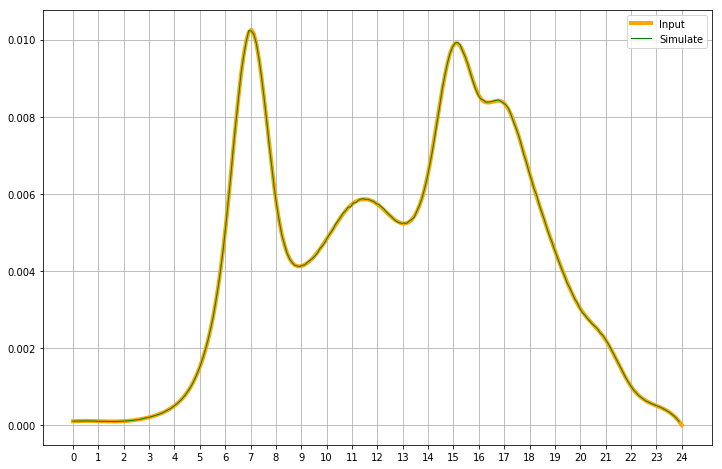

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(xs, ys, color='orange', linewidth=4, label='Input')
ax.plot(bin_edges[:-1], hist, color='green', linewidth=1, label='Simulate')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)
ax.legend()

### Simulation with Arbitrary Period Totals

In [17]:
trips = [int(SAMPLE_SIZE*s) for s in omx_period_totals]
periods = [[(6,9)], [(9,15)], [(15,19)], [(0,6),(19,24)]]

In [18]:
start = time.clock()
departure_times = np.array([])
for trip, period in zip(trips, periods):
    departure_times = np.concatenate([departure_times,dt_gen.dt(period, trip)])
end = time.clock()
print("Total Processing Time = {0:.2f} seconds".format(end-start))

Total Processing Time = 2.10 seconds


In [19]:
hist, bin_edges = np.histogram(departure_times, bins=dt_gen._x_interp, density=False)
hist = hist / sum(hist)

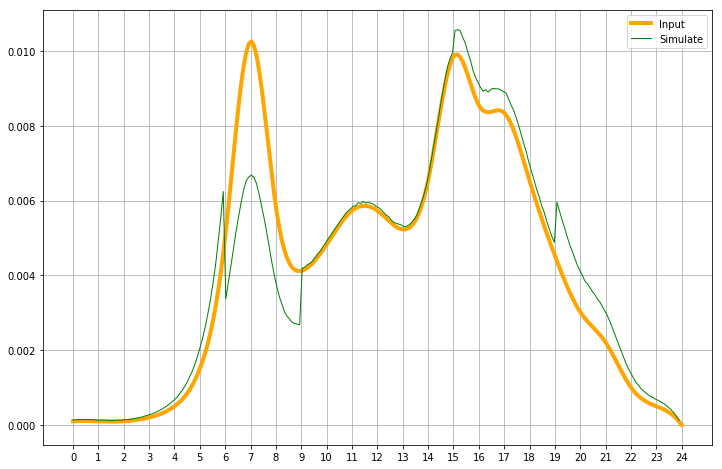

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(xs, ys, color='orange', linewidth=4, label='Input')
ax.plot(bin_edges[:-1], hist, color='green', linewidth=1, label='Simulate')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)
ax.legend()

### Scratch

In [31]:
md_intervals = df_input_diurnal.loc[(df_input_diurnal.HOUR >= 9) & (df_input_diurnal.HOUR < 15), 'HOUR'].values
md_intervals

array([ 9.037657,  9.138075,  9.238494,  9.338912,  9.439331,  9.539749,
        9.640167,  9.740586,  9.841004,  9.941423, 10.041841, 10.142259,
       10.242678, 10.343096, 10.443515, 10.543933, 10.644351, 10.74477 ,
       10.845188, 10.945607, 11.046025, 11.146444, 11.246862, 11.34728 ,
       11.447699, 11.548117, 11.648536, 11.748954, 11.849372, 11.949791,
       12.050209, 12.150628, 12.251046, 12.351464, 12.451883, 12.552301,
       12.65272 , 12.753138, 12.853556, 12.953975, 13.054393, 13.154812,
       13.25523 , 13.355649, 13.456067, 13.556485, 13.656904, 13.757322,
       13.857741, 13.958159, 14.058577, 14.158996, 14.259414, 14.359833,
       14.460251, 14.560669, 14.661088, 14.761506, 14.861925, 14.962343])

In [28]:
stimes_sample = dt_gen.dt([(9,15)], 10000)

In [29]:
stimes_sample[np.where((stimes_sample >= 11.95) & (stimes_sample < 12.05))]

array([], dtype=float64)

In [30]:
stimes_sample

array([11.648536, 11.548117, 14.661088, ..., 13.054393, 14.560669,
       12.552301])

In [38]:
np.arange(0, 24.1, 0.1)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

In [36]:
range(0, 24.1, 0.1)

TypeError: 'float' object cannot be interpreted as an integer